In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/final_labels.csv', index_col=0)

## Log Reg over lemmatized text

In [3]:
df

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
1219,"так, присутня негативна",так,так,row_0.txt,snizannabotvin@gmail.com,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",4
1218,"ні, оцінка не присутня",ні,ні,row_1.txt,snizannabotvin@gmail.com,Литературный критик Галина Юзефович о новом ро...,4
1591,"так, присутня негативна",так,так,row_10.txt,snizannabotvin@gmail.com,Почему на базах неонацистов стоят языческие ис...,4
1198,"так, присутня негативна",так,так,row_100.txt,snizannabotvin@gmail.com,Группа добровольцев-медиков из Чеченской Респу...,4
3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5
...,...,...,...,...,...,...,...
3613,"ні, оцінка не присутня",ні,так,row_995.txt,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5
3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5
4121,"так, присутня негативна",ні,так,row_997.txt,yevhen.marchenko91@gmail.com,Наш соратник по русскому движению Алексей Сели...,3
4120,"ні, оцінка не присутня",так,так,row_998.txt,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3


In [4]:
df_dehumanization = df[['Dehumanization', 'text']].reset_index(drop=True)

In [5]:
df_dehumanization = df_dehumanization[df_dehumanization['Dehumanization']!='не можу визначитись з правильною відповіддю']

In [6]:
len(df_dehumanization)

3494

In [7]:
df_dehumanization['label'] = df_dehumanization['Dehumanization'].apply(lambda x: 0 if x=='ні' else 1)

In [8]:
df_dehumanization

,Dehumanization,text,label
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1
1,ні,Литературный критик Галина Юзефович о новом ро...,0
2,так,Почему на базах неонацистов стоят языческие ис...,1
3,так,Группа добровольцев-медиков из Чеченской Респу...,1
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0
...,...,...,...
3541,ні,Утренний брифинг Минобороны России: ▪️ россий...,0
3542,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0
3543,ні,Наш соратник по русскому движению Алексей Сели...,0
3544,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1


## Preprocessing

In [9]:
import spacy
nlp = spacy.load('ru_core_news_md',disable=['ner', 'attribute_ruler'])

def lemmatize_spacy(text):
    doc = nlp(text)
    result = " ".join([token.lemma_ for token in doc])
    return result

In [10]:
cyrillic_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ "

def clean_text(string, allowed_symbols):
    getVals = list(filter(lambda x: x in allowed_symbols, string))
    result = "".join(getVals)
    return result

In [11]:
def preprocess_df(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
    df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
    df=df[df['text_clean']!='']
    df.reset_index(inplace=True)
    return df

In [12]:
%%time
df_dehumanization = preprocess_df(df_dehumanization)

CPU times: user 20 s, sys: 197 ms, total: 20.2 s
Wall time: 21.7 s


## Logreg

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_, X_test_, y_train, y_test = train_test_split(df_dehumanization["text_clean"], df_dehumanization["label"], test_size=0.2, random_state=42)

In [14]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_)
X_test = vectorizer.transform(X_test_)

In [15]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.77
Precision: 0.82
Recall: 0.66
F1 Score: 0.73


### Gridsearch

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

logreg_best = grid_search.best_estimator_

logreg_best.fit(X_train, y_train)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [18]:
y_pred = logreg_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.78
Precision: 0.79
Recall: 0.72
F1 Score: 0.75


In [19]:
best_params = logreg_best.get_params()
print("Best hyperparameters for the logistic regression model:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


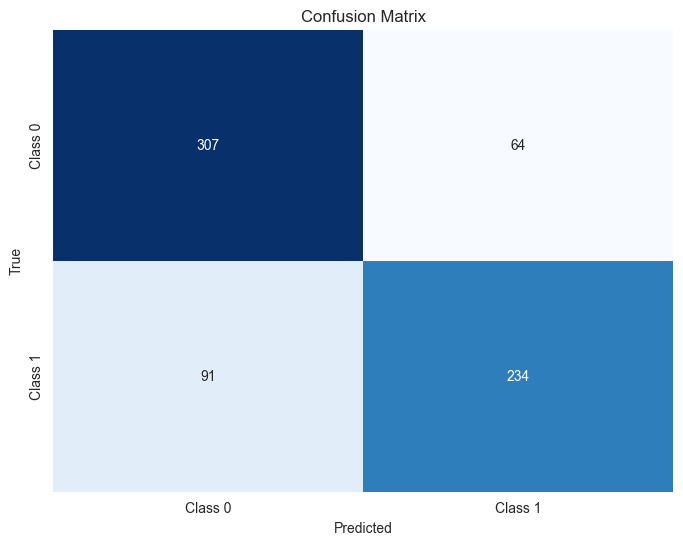

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
original_data = df_dehumanization.loc[X_test_.index]

In [22]:
original_data['Predicted Label'] = y_pred
original_data['Prediction Status'] = original_data['label'] == original_data['Predicted Label']
incorrect_predictions = original_data[~original_data['Prediction Status']]

In [23]:
print("Incorrectly predicted samples:")
for index, row in incorrect_predictions.iterrows():
    print(f"Index: {index}\nOriginal Text: {row['text']}\nTrue Label: {row['label']}\nPredicted Label: {row['Predicted Label']}\n")

Incorrectly predicted samples:
Index: 2396
Original Text: Ведь безо всякой конкуренции, по словам ряда источников, Zе обходит Залужный, а антирейтинг Ze делают посаженные им в СИЗО генералы и посаженные на места "слуги народу"  П.С. упоминания РФ и РБ из рейтинга убрали, пусть хохлы упражняются в острословии сами для себя и между собой
True Label: 0
Predicted Label: 1

Index: 1175
Original Text: В 2004 году проскакались за демократию, к власти пришел Ющенко, "Оранжевая революция".  2006 и 2007 год, скачки за Тимошенко и Ющенко.  2010 год, "налоговый Майдан", правительство Азарова согласилось пересмотреть нормы налогового кодекса.  2012, "языковой Майдан", успех партии бандеровцев и нацистов "Свобода".  2013 год, март-август, опять "Восстань Украина", партии Фронт перемен, Удар, Свобода.  2013 год, ноябрь-декабрь, собственно Евромайдан.  2014 год, январь-март и по настоящее время, "Революция достоинства".  ...  2020 год - ситуация в дурдоме стабильна.
True Label: 1
Predicted Label: 0

I

### Preliminary error analysis

Укрвояки сприймається системою як дегуманізація

Рядок 2562, 2210, 1288, 1188, 291, 2486 - сумнівний лейбл, цілком можливо що система права

Хохлофейки тригерить систему

Чомусь тригерить коронавірус (93, 33)

Не впізнає місцями свинорейх (як в 3419, 170)

Майже весь неонацизм постійно тригерить систему - 2775, 1011, 289 (але от в 2320 - неонацизм как раковая опухоль - ні, 3193 - )

1070 - система тригериться на чубатих

Система гірше зчитує subtle cues - 554 (накапливаются), 2335 (зондероотряд), 486 (не бандероукропианці, а держава = навоз), 2646 (опис а не фразеологізм)

Не всі атрибути нацизма впізнає - 678 (бандерюгенд), 2335 (зондероотряд), 2293 (бандерофашисти)

2086 - укропские мартішки




## Log Reg over lemmatized text plus (or exclusively) collocations (with concatenaction)

In [24]:
from collocation_extraction import collect_verb_obl_obj, collect_core, collect_nmod, collect_amod, collect_comp, collect_appos, show_dependency, lst_to_str

In [15]:
df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_dehumanization['nmod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_dehumanization['amod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_amod(x)))
df_dehumanization['comp'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_comp(x)))

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_1265/1996300300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_1265/1996300300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
/var/folders/2w/hygxgpp5353_dy_tk8

In [16]:
df_dehumanization.drop(columns='index', inplace=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_1265/2166550837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization.drop(columns='index', inplace=True)


In [ ]:
df_dehumanization

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def get_logreg_best(col_list = ['text_lemmatized'], df=df_dehumanization, vectorizer = TfidfVectorizer(), random_state=42):
    df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    X_train_, X_test_, y_train, y_test = train_test_split(df["merged_col"], df["label"], test_size=0.2, random_state=random_state)
    X_train = vectorizer.fit_transform(X_train_)
    X_test = vectorizer.transform(X_test_)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=random_state), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)
    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    best_params = logreg_best.get_params()
    print("Best hyperparameters for the logistic regression model:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

In [30]:
get_logreg_best()

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.81
Precision: 0.82
Recall: 0.75
F1 Score: 0.79
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
get_logreg_best(col_list=['text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.78
Precision: 0.79
Recall: 0.72
F1 Score: 0.75
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [32]:
get_logreg_best(col_list=['core_noun_verb'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.61
Precision: 0.70
Recall: 0.30
F1 Score: 0.42
Best hyperparameters for the logistic regression model:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
get_logreg_best(col_list=['verb_obl_obj'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.58
Precision: 0.57
Recall: 0.39
F1 Score: 0.46
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
get_logreg_best(col_list=['nmod'])


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.65
Precision: 0.66
Recall: 0.49
F1 Score: 0.56
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
get_logreg_best(col_list=['amod'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.58
Precision: 0.59
Recall: 0.36
F1 Score: 0.45
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.69
Precision: 0.70
Recall: 0.57
F1 Score: 0.63
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.75
Precision: 0.80
Recall: 0.62
F1 Score: 0.70
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod'])


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.75
Precision: 0.79
Recall: 0.64
F1 Score: 0.71
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.79
Precision: 0.82
Recall: 0.70
F1 Score: 0.76
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [40]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.82
Precision: 0.85
Recall: 0.74
F1 Score: 0.79
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [41]:
df_dehumanization.columns

Index(['Dehumanization', 'text', 'label', 'text_clean', 'text_lemmatized',
       'core_noun_verb', 'verb_obl_obj', 'nmod', 'amod', 'comp', 'merged_col'],
      dtype='object')

## Log Reg over lemmatized text plus (or exclusively) collocations (as separate features)

In [42]:
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_logistic_regression(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('regressor', LogisticRegression(solver='liblinear', random_state=random_state, max_iter=100))
    ])

    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        'regressor__penalty': ['l1', 'l2']
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)

    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return logreg_best

In [18]:
text_columns = ['nmod', 'verb_obl_obj']
label_column = ['label']

In [44]:
%%time
trained_pipeline = train_logistic_regression(df_dehumanization, text_columns, label_column)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

Accuracy: 0.69
Precision: 0.70
Recall: 0.58
F1 Score: 0.64
CPU times: user 1min 12s, sys: 26.9 s, total: 1min 39s
Wall time: 34.3 s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
%%time
text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

trained_pipeline = train_logistic_regression(df_dehumanization, text_columns, label_column)

Accuracy: 0.78
Precision: 0.80
Recall: 0.71
F1 Score: 0.75
CPU times: user 2min 9s, sys: 1min 14s, total: 3min 24s
Wall time: 50.8 s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Feature importance

### Feature importance of unique vectors

In [19]:
def get_feature_names(vectorizer):
    feature_names = []
    for col, vec in zip(vectorizer.columns, vectorizer.vectorizers):
        feature_names.extend([f"{col}_{f}" for f in vec.get_feature_names_out()])
    return feature_names

In [20]:
import numpy as np
def display_feature_importance(pipeline, n=10):
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['regressor']
    feature_names = get_feature_names(vectorizer)
    coefficients = classifier.coef_[0]
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    print(f"Top {n} important features:")
    for i in sorted_indices[:n]:
        print(f"{feature_names[i]}: {coefficients[i]}")

In [48]:
display_feature_importance(trained_pipeline)

Top 10 important features:
text_lemmatized_укронацистов: 6.378262550346116
text_lemmatized_неонацист: 6.085057392767983
core_noun_verb_укронацисты: 5.91855169444555
text_clean_укронацистов: 5.899070697524357
text_lemmatized_укрорейха: 5.276251591374416
nmod_укронацистов: 5.018582192359891
text_clean_укрорейха: 4.852979284465811
text_lemmatized_укронацисты: 4.632180415751175
text_clean_укронацисты: 4.249282732972154
nmod_укрорейха: 4.186660657334475


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

tfidf_vectorizer = TfidfVectorizer(max_features=10000)

top_features = pd.DataFrame()

# looping over each text column and apply TF-IDF vectorization followed by chi-squared test
for col in text_columns:
    tfidf_features = tfidf_vectorizer.fit_transform(df_dehumanization[col])

    # chi-squared test to select the top-k features with the lowest p-values
    selector = SelectKBest(chi2, k=100)
    selector.fit(tfidf_features, df_dehumanization['label'])
    feature_scores = pd.DataFrame({
        'feature': tfidf_vectorizer.get_feature_names_out(),
        'p_value': selector.pvalues_,
    })

    # sorting the features by p-value and add the top-k features to the top_features
    top_k_features = feature_scores.sort_values(by='p_value').head(100)['feature']
    top_features[col] = top_k_features

final_features = pd.concat([top_features[col] for col in top_features.columns]).unique().tolist()

In [50]:
final_features

['укронацистов',
 'укрорейха',
 'неонацистов',
 'чубайса',
 'укропитеков',
 'донецка',
 'укронацисты',
 'всушников',
 'салорейха',
 'нацистов',
 'президента',
 'обстрела',
 'москве',
 'хохлорейха',
 'укронациста',
 'города',
 'шайкой',
 'боевиков',
 'горловки',
 'свинособаки',
 'пропаганды',
 'укронацизма',
 'неонацистами',
 'коронавируса',
 'укрорейхом',
 'оружия',
 'наркоманов',
 'свинорейха',
 'позициям',
 'бригады',
 'хозяева',
 'мид',
 'укронацистами',
 'подразделений',
 'укрорейху',
 'жизней',
 'атаки',
 'обстрелы',
 'задача',
 'их',
 'укрорейхе',
 'захвата',
 'нациков',
 'укронациков',
 'позиции',
 'рядах',
 'координаты',
 'рублей',
 'смерти',
 'дислокации',
 'перемога',
 'представитель',
 'лица',
 'работа',
 'неонацисты',
 'атаку',
 'режима',
 'новостей',
 'склады',
 'стиле',
 'жители',
 'утилизации',
 'хунты',
 'всу',
 'воевать',
 'новости',
 'коронавирусом',
 'командование',
 'место',
 'тактике',
 'уничтожить',
 'сектора',
 'освобождения',
 'войск',
 'рсзо',
 'просвещения',
 

In [51]:
df = pd.DataFrame(final_features, columns=['final_features'])
df.to_json('most_important_features.json')

## Importance of columns (ie collocations and versions of pre-processing)


### Averaged importance

In [52]:
def get_average_importance(trained_pipeline):
    multi_column_tfidf_vectorizer = trained_pipeline.named_steps['vectorizer']
    logistic_regression = trained_pipeline.named_steps['regressor']
    coef = logistic_regression.coef_

    column_importance = pd.DataFrame()
    start = 0
    for i, col in enumerate(multi_column_tfidf_vectorizer.columns):
        vec = multi_column_tfidf_vectorizer.fitted_models[i]
        end = start + len(vec.get_feature_names_out())
        feature_scores = pd.DataFrame({
            'feature': vec.get_feature_names_out(),
            'importance': abs(coef[0][start:end])
        })
        column_importance[col] = feature_scores.set_index('feature')['importance']
        start = end

    mean_importance = column_importance.mean(axis=0).sort_values(ascending=False)
    return mean_importance

In [53]:
mean_importance = get_average_importance(trained_pipeline)
print(mean_importance)

core_noun_verb     0.259424
text_lemmatized    0.249534
amod               0.235747
nmod               0.207353
verb_obl_obj       0.189647
text_clean         0.162578
dtype: float64


### Importance of columns by permutation

In [21]:
from itertools import combinations, chain

text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

all_col_variations = list(chain.from_iterable(combinations(text_columns, r) for r in range(1, len(text_columns)+1)))
all_col_variations = [list(p) for p in all_col_variations]
all_col_variations

[['nmod'],
 ['verb_obl_obj'],
 ['core_noun_verb'],
 ['amod'],
 ['text_lemmatized'],
 ['text_clean'],
 ['nmod', 'verb_obl_obj'],
 ['nmod', 'core_noun_verb'],
 ['nmod', 'amod'],
 ['nmod', 'text_lemmatized'],
 ['nmod', 'text_clean'],
 ['verb_obl_obj', 'core_noun_verb'],
 ['verb_obl_obj', 'amod'],
 ['verb_obl_obj', 'text_lemmatized'],
 ['verb_obl_obj', 'text_clean'],
 ['core_noun_verb', 'amod'],
 ['core_noun_verb', 'text_lemmatized'],
 ['core_noun_verb', 'text_clean'],
 ['amod', 'text_lemmatized'],
 ['amod', 'text_clean'],
 ['text_lemmatized', 'text_clean'],
 ['nmod', 'verb_obl_obj', 'core_noun_verb'],
 ['nmod', 'verb_obl_obj', 'amod'],
 ['nmod', 'verb_obl_obj', 'text_lemmatized'],
 ['nmod', 'verb_obl_obj', 'text_clean'],
 ['nmod', 'core_noun_verb', 'amod'],
 ['nmod', 'core_noun_verb', 'text_lemmatized'],
 ['nmod', 'core_noun_verb', 'text_clean'],
 ['nmod', 'amod', 'text_lemmatized'],
 ['nmod', 'amod', 'text_clean'],
 ['nmod', 'text_lemmatized', 'text_clean'],
 ['verb_obl_obj', 'core_noun_

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_logistic_regression(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('regressor', LogisticRegression(solver='liblinear', random_state=random_state, max_iter=100))
    ])

    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        'regressor__penalty': ['l1', 'l2']
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)

    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return logreg_best, [accuracy, precision, recall, f1]

In [56]:
%%time
all_trained_pipelines = []
all_results = []
for col_set in all_col_variations:
    current_pipe, results = train_logistic_regression(df_dehumanization, col_set, label_column)
    all_trained_pipelines.append(current_pipe)
    all_results.append(results)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

CPU times: user 1h 30min 46s, sys: 49min 12s, total: 2h 19min 58s
Wall time: 37min 20s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
idx_largest = max(range(len(all_results)), key=lambda i: all_results[i][-1])

next_largest = max([all_results[i][-1] for i in range(len(all_results)) if all_results[i][-1] < all_results[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results)) if all_results[i][-1] == next_largest])

print(idx_next_largest)

36


In [58]:
all_results[idx_largest]

[0.8074712643678161,
 0.8193979933110368,
 0.7538461538461538,
 0.7852564102564102]

In [59]:
all_trained_pipelines[idx_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['text_lemmatized'])),
                ('regressor',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [60]:
all_trained_pipelines[idx_next_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['verb_obl_obj',
                                                     'text_lemmatized',
                                                     'text_clean'])),
                ('regressor',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [61]:
all_results[idx_next_largest]

[0.8074712643678161,
 0.8281786941580757,
 0.7415384615384616,
 0.7824675324675325]

## SVM

In [62]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [22]:
label_column = ['label']

In [64]:
class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_svm(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        # 'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train, y_train)

    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return svm_best, [accuracy, precision, recall, f1]


In [65]:
%%time
all_trained_pipelines = []
all_results = []
for col_set in all_col_variations:
    current_pipe, results = train_svm(df_dehumanization, col_set, label_column)
    all_trained_pipelines.append(current_pipe)
    all_results.append(results)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-pack

CPU times: user 39min 20s, sys: 14.2 s, total: 39min 34s
Wall time: 1h 15min 57s


In [66]:
idx_largest = max(range(len(all_results)), key=lambda i: all_results[i][-1])

next_largest = max([all_results[i][-1] for i in range(len(all_results)) if all_results[i][-1] < all_results[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results)) if all_results[i][-1] == next_largest])

print(idx_next_largest)

39


In [67]:
all_results[idx_largest]

[0.7945402298850575,
 0.8053691275167785,
 0.7384615384615385,
 0.7704654895666131]

In [68]:
all_trained_pipelines[idx_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['text_lemmatized'])),
                ('classifier', SVC(C=1, kernel='linear', random_state=42))])

In [69]:
all_trained_pipelines[idx_largest].get_params()

{'memory': None,
 'steps': [('vectorizer',
   MultiColumnTfidfVectorizer(columns=['text_lemmatized'])),
  ('classifier', SVC(C=1, kernel='linear', random_state=42))],
 'verbose': False,
 'vectorizer': MultiColumnTfidfVectorizer(columns=['text_lemmatized']),
 'classifier': SVC(C=1, kernel='linear', random_state=42),
 'vectorizer__columns': ['text_lemmatized'],
 'classifier__C': 1,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear',
 'classifier__max_iter': -1,
 'classifier__probability': False,
 'classifier__random_state': 42,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

In [70]:
df_dehumanization

,Dehumanization,text,label,text_clean,text_lemmatized,core_noun_verb,verb_obl_obj,nmod,amod,comp,merged_col
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1,всвязи с этим немного поправлю коллег они не...,всвязи с это немного поправить коллега они ...,"Всвязи немного поправлю, Они не начинать, мы д...","немного поправлю коллег, не начинать армагеддо...","Всвязи с этим, диверсии в Польше, удар ТЯО, уд...","ядерный армагеддон, осознанный удар, Львовской...",,"Всвязи с этим, диверсии в Польше, удар ТЯО, уд..."
1,ні,Литературный критик Галина Юзефович о новом ро...,0,литературный критик галина юзефович о новом ро...,литературный критик галина юзефович о новый ро...,"критик все состоит, достоинство все состоит, э...","состоит в том, захватывающе читать которую","критик петербуржца романе, романе петербуржца,...","Литературный критик, новом романе, Главное дос...",,"критик петербуржца романе, романе петербуржца,..."
2,так,Почему на базах неонацистов стоят языческие ис...,1,почему на базах неонацистов стоят языческие ис...,почему на база неонацист стоять языческий исту...,истуканы Почему стоят,Почему стоят на базах,"базах неонацистов, Гость студии, протоиерей СМ...",языческие истуканы,,"базах неонацистов, Гость студии, протоиерей СМ..."
3,так,Группа добровольцев-медиков из Чеченской Респу...,1,группа добровольцевмедиков из чеченской респуб...,группа добровольцевмедиков из чеченский респуб...,"Группа наравне вносит, врачи оказывают","вносит лепту, вносит в дело, вносит -, вносит ...","Группа добровольцев, Группа -, Группа медиков,...","бандеровских мразей, подлых шайтанов, Республи...",,"Группа добровольцев, Группа -, Группа медиков,..."
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0,всушники переходите на сторону добра у нас теп...,всушники переходить на сторона добро у нас тёп...,"ВСУшники переходите, тепло нас",переходите на сторону,сторону добра,вкусные печеньки,,сторону добра переходите на сторону ВСУшники п...
...,...,...,...,...,...,...,...,...,...,...,...
3474,ні,Утренний брифинг Минобороны России: ▪️ россий...,0,утренний брифинг минобороны россии российски...,утренний брифинг минобороны россия российск...,"брифинг продвинулись, силы продвинулись, групп...","продвинулись за ночь, продвинулись на км, разв...","брифинг Минобороны, наступление бригады подраз...","Утренний брифинг, российские силы, украинской ...",,"брифинг Минобороны, наступление бригады подраз..."
3475,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0,и понеслась мазепинщинопетлюровщинобандеровщина,и понестись мазепинщинопетлюровщинобандеровщина,,"понеслась петлюровщино, понеслась -, понеслась...",,,,"понеслась петлюровщино, понеслась -, понеслас..."
3476,ні,Наш соратник по русскому движению Алексей Сели...,0,наш соратник по русскому движению алексей сели...,наш соратник по русский движение алексей селив...,соратник вместе прибыл,"прибыл в область, создавать органы, создавать ...","соратник русскому движению, армией России, орг...","русскому движению, Запорожскую область, мирной...",,"соратник русскому движению, армией России, орг..."
3477,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1,хорошее видео от бригады нм лнр обработка по...,хороший видео от бригада нм лнр обработка ...,,,"видео НМ бригады, бригады НМ, обработка позици...","Хорошее видео, пифтонными бомбами",,"видео НМ бригады, бригады НМ, обработка позици..."


## With augmentation

In [23]:
import pandas as pd
# df_rm = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_removed_dehumanization.csv', index_col=[0])

In [24]:
from collocation_extraction import collect_verb_obl_obj, collect_core, collect_nmod, collect_amod, collect_comp, collect_appos, show_dependency, lst_to_str
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline


In [25]:
# df_add = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_added_dehumanization.csv', index_col=[0])
df_augmentation = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_neutal_in_class.csv', index_col=[0])

In [26]:
df_augmentation

,index,Emotion,Dehumanization,Mention,External ID,Created By,text,rating,text_clean,text_lemmatized,found_ukrainians,replaced_neutral_sent_ukrainians
3,3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5,"всушники, переходите на сторону добра, у нас т...","['всушники', ',', 'переходить', 'на', 'сторона...","[{'lemma': 'всушник', 'position': 0, 'morph_fo...","украинцы, переходите на сторону добра, у нас т..."
4,3246,"ні, оцінка не присутня",ні,так,row_1001.txt,tutovadesign@gmail.com,Наши ребята столкнулись с полком «Азов» и морс...,5,наши ребята столкнулись с полком азов и морско...,"['наш', 'ребята', 'столкнуться', 'с', 'полок',...","[{'lemma': 'всу', 'position': 9, 'morph_form':...",наши ребята столкнулись с полком азов и морско...
8,3240,"ні, оцінка не присутня",ні,так,row_1007.txt,tutovadesign@gmail.com,⚡️ВСУ нанесли артиллерийский удар по больнице ...,5,всу нанесли артиллерийский удар по больнице в ...,"['всу', 'нанести', 'артиллерийский', 'удар', '...","[{'lemma': 'всу', 'position': 0, 'morph_form':...",украинцы нанесли артиллерийский удар по больни...
10,3238,"ні, оцінка не присутня",ні,так,row_1009.txt,tutovadesign@gmail.com,Применение Коллективных сил Организации Догово...,5,применение коллективных сил организации догово...,"['применение', 'коллективный', 'сила', 'органи...",[],применение коллективных сил организации догово...
12,3288,"ні, оцінка не присутня",ні,так,row_1011.txt,tutovadesign@gmail.com,"В этом списке есть Кум, есть уважаемые партнер...",5,"в этом списке есть кум, есть уважаемые партнер...","['в', 'этот', 'список', 'быть', 'кум', ',', 'б...",[],"в этом списке есть кум, есть уважаемые партнер..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2402,"так, присутня негативна",ні,так,row_99.txt,nazariy.melnychuk9@gmail.com,🇺🇦❌Очередной фейк укропропаганды Укропаблики ...,7,очередной фейк укропропаганды укропаблики сег...,"['очередной', 'фейк', 'укропропаганды', ' ', '...",[],очередной фейк укропропаганды укропаблики сег...
2494,3615,"ні, оцінка не присутня",ні,так,row_993.txt,tutovadesign@gmail.com,"⚡️Путин: Нам нужно ответить на вопрос, который...",5,"путин: нам нужно ответить на вопрос, который п...","['путин', ':', 'нам', 'нужный', 'ответить', 'н...",[],"путин: нам нужно ответить на вопрос, который п..."
2495,3613,"ні, оцінка не присутня",ні,так,row_995.txt,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5,утренний брифинг минобороны россии: российск...,"['утренний', 'брифинг', 'минобороны', 'россия'...",[],утренний брифинг минобороны россии: российск...
2496,3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5,и понеслась мазепинщино-петлюровщино-бандеровщ...,"['и', 'понестись', 'мазепинщино', '-', 'петлюр...",[],и понеслась мазепинщино-петлюровщино-бандеровщ...


In [51]:
# df_augmentation = pd.concat([df_rm,df_add])
# df_augmentation = df_add.copy()

In [52]:
# def preprocess_df_(df):
#     df['text_clean'] = df['fixed_sentences'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
#     df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
#     df=df[df['text_clean']!='']
#     df.reset_index(inplace=True)
#     return df

In [53]:
from itertools import combinations, chain

text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

all_col_variations = list(chain.from_iterable(combinations(text_columns, r) for r in range(1, len(text_columns)+1)))
all_col_variations = [list(p) for p in all_col_variations]

In [54]:
label_column = ['label']

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
%%time

df_augmentation = preprocess_df(df_augmentation)

CPU times: user 4.76 s, sys: 36.4 ms, total: 4.8 s
Wall time: 4.8 s


In [28]:
df_augmentation['core_noun_verb'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_core(x)))
df_augmentation['verb_obl_obj'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_augmentation['nmod'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_augmentation['amod'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_amod(x)))
df_augmentation['comp'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_comp(x)))

In [82]:
df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_dehumanization['nmod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_dehumanization['amod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_amod(x)))
df_dehumanization['comp'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_comp(x)))

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/1996300300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_40366/1996300300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
/var/folders/2w/hygxgpp5353_dy_t

In [29]:
df_augmentation['label']=0

In [84]:
def train_augmented_svm(data, augmentation_data, text_columns, label_column, random_state=42):
    total_data_size = len(data) + len(augmentation_data)
    desired_test_size = int(total_data_size * 0.2)
    adjusted_test_size_ratio = desired_test_size / len(data)

    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)

    X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
    y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)

    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())

    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test.values.ravel(), y_pred)
    precision = precision_score(y_test.values.ravel(), y_pred)
    recall = recall_score(y_test.values.ravel(), y_pred)
    f1 = f1_score(y_test.values.ravel(), y_pred)

    return svm_best, [accuracy, precision, recall, f1]


In [85]:
%%time
all_trained_pipelines_svm = []
all_results_svm = []
for col_set in all_col_variations:
    current_pipe, results = train_augmented_svm(df_dehumanization, df_augmentation, col_set, label_column)
    all_trained_pipelines_svm.append(current_pipe)
    all_results_svm.append(results)

CPU times: user 55min 52s, sys: 17.6 s, total: 56min 10s
Wall time: 1h 3min 36s


In [86]:
idx_largest = max(range(len(all_results_svm)), key=lambda i: all_results_svm[i][-1])

next_largest = max([all_results_svm[i][-1] for i in range(len(all_results_svm)) if all_results_svm[i][-1] < all_results_svm[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results_svm)) if all_results_svm[i][-1] == next_largest])

print(idx_next_largest)

40


In [87]:
all_results_svm[idx_largest]


[0.8587830080367393, 0.941358024691358, 0.7457212713936431, 0.8321964529331514]

In [88]:
all_trained_pipelines_svm[idx_largest].get_params()

{'memory': None,
 'steps': [('vectorizer',
   MultiColumnTfidfVectorizer(columns=['text_lemmatized', 'text_clean'])),
  ('classifier', SVC(C=100, kernel='linear', random_state=42))],
 'verbose': False,
 'vectorizer': MultiColumnTfidfVectorizer(columns=['text_lemmatized', 'text_clean']),
 'classifier': SVC(C=100, kernel='linear', random_state=42),
 'vectorizer__columns': ['text_lemmatized', 'text_clean'],
 'classifier__C': 100,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear',
 'classifier__max_iter': -1,
 'classifier__probability': False,
 'classifier__random_state': 42,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

## Signals from lexicons

In [89]:
# df_RuSentiLex = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/lexicons/RuSentiLex.csv', sep=';')

In [90]:
# df_RuSentiLex

,word,pos,lemma,sentiment,source,ambiguity,rest
0,аборт,Noun,аборт,negative,fact,NaN,NaN
1,абортивный,Adj,абортивный,negative,fact,NaN,NaN
2,абракадабра,Noun,абракадабра,negative,opinion,NaN,NaN
3,абсурд,Noun,абсурд,negative,opinion,NaN,NaN
4,абсурдность,Noun,абсурдность,negative,opinion,NaN,NaN
...,...,...,...,...,...,...,...
16049,ярый,Adj,ярый,positive,opinion,ПРЕДАННЫЙ,NaN
16050,ясность,Noun,ясность,positive,opinion,NaN,NaN
16051,ясный,Adj,ясный,positive,opinion,NaN,NaN
16052,ящур,Noun,ящур,negative,fact,NaN,NaN


## Separate metrics

In [98]:
# define function that separates the testing data
# y_target_labels_test, y_general_test
import pandas as pd
import ast
import numpy as np
from gensim.models import Word2Vec
from datetime import timedelta

In [94]:
model_path = "/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/final_models/full_dataset_word2vec_correct.model"
gensim_model = Word2Vec.load(model_path)

In [95]:
def load_dictionary_from_file(file_name):
    with np.load(file_name) as data:
        return {key: data[key] for key in data}

In [96]:
centroids_dict = load_dictionary_from_file('centroids_dict.npz')

In [99]:
# def find_closest_words_for_single_model(model_path: str, given_vector, topn: int = 10):
#     try:
#         model = Word2Vec.load(model_path)
#         closest_words = model.wv.similar_by_vector(given_vector, topn=topn)
#         return closest_words
#     except Exception as e:
#         print(f"Error processing model {model_path}: {e}")
#         return []

In [111]:
%%time

closest_words = []

for vector in centroids_dict.values():
    closest_words_vector = gensim_model.wv.similar_by_vector(vector, topn=20)
    closest_words.append(closest_words_vector)

closest_words = [num for sublist in closest_words for num in sublist]

CPU times: user 1.08 s, sys: 477 ms, total: 1.56 s
Wall time: 222 ms


In [112]:
len(closest_words)

240

In [ ]:
closest_words

In [31]:
dehumanizing_target_labels = ['укрорейха', 'нацистка', 'укропитеки', 'свинособаки', 'бандерлоги', 'свинорылых', 'укронацистов', 'укропитеков', 'укронацистская', 'укровермахта']

In [30]:
dehumanizing_target_sequences = ['рейх', 'нацист', 'питек', 'бандерло', 'свино', 'вермахт', 'питек']

In [117]:
# import json
#
# with open('dehumanizing_target_sequences.json', 'w') as f:
#     json.dump(dehumanizing_target_sequences, f)

In [ ]:
# with open('dehumanizing_target_sequences.json', 'r') as f:
#     new_list = json.load(f)

In [32]:
import re

def contains_target_sequence(text, target_sequences):
    # text = text.decode("utf-8")
    for seq in target_sequences:
        if re.search(seq, text, re.IGNORECASE):
            return True
    return False

In [125]:
contains_target_sequence('бандерлог укропитека', dehumanizing_target_sequences)

True

In [33]:
def split_test_data_by_target_sequences(X, y, text_columns, target_sequences):
    contains_seq = X.apply(lambda row: any(contains_target_sequence(row[col], target_sequences) for col in text_columns), axis=1)
    X_pos, y_pos = X[contains_seq], y[contains_seq]
    X_neg, y_neg = X[~contains_seq], y[~contains_seq]

    return X_pos, y_pos, X_neg, y_neg

## Model selection based on the combined F1

In [128]:
def train_augmented_svm(data, augmentation_data, text_columns, label_column, dehumanizing_target_sequences, random_state=42):
    total_data_size = len(data) + len(augmentation_data)
    desired_test_size = int(total_data_size * 0.2)
    adjusted_test_size_ratio = desired_test_size / len(data)

    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)

    X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
    y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)

    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())

    X_test_pos, y_test_pos, X_test_neg, y_test_neg = split_test_data_by_target_sequences(X_test, y_test, text_columns, dehumanizing_target_sequences)

    y_pred_pos = svm_best.predict(X_test_pos)
    accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
    precision_pos = precision_score(y_test_pos, y_pred_pos)
    recall_pos = recall_score(y_test_pos, y_pred_pos)
    f1_pos = f1_score(y_test_pos, y_pred_pos)

    y_pred_neg = svm_best.predict(X_test_neg)
    accuracy_neg = accuracy_score(y_test_neg, y_pred_neg)
    precision_neg = precision_score(y_test_neg, y_pred_neg)
    recall_neg = recall_score(y_test_neg, y_pred_neg)
    f1_neg = f1_score(y_test_neg, y_pred_neg)

    return svm_best, [(accuracy_pos, precision_pos, recall_pos, f1_pos), (accuracy_neg, precision_neg, recall_neg, f1_neg)]

In [129]:
%%time
all_trained_pipelines_svm = []
all_results_svm = []
for col_set in all_col_variations:
    current_pipe, (results_pos, results_neg) = train_augmented_svm(df_dehumanization, df_augmentation, col_set, label_column, dehumanizing_target_sequences)
    all_trained_pipelines_svm.append(current_pipe)
    all_results_svm.append({"results_pos": results_pos, "results_neg": results_neg})

CPU times: user 56min 21s, sys: 23.7 s, total: 56min 45s
Wall time: 1h 45min 20s


In [131]:
idx_largest_pos = max(range(len(all_results_svm)), key=lambda i: all_results_svm[i]["results_pos"][-1])
idx_largest_neg = max(range(len(all_results_svm)), key=lambda i: all_results_svm[i]["results_neg"][-1])

next_largest_pos = max([all_results_svm[i]["results_pos"][-1] for i in range(len(all_results_svm)) if all_results_svm[i]["results_pos"][-1] < all_results_svm[idx_largest_pos]["results_pos"][-1]])
idx_next_largest_pos = max([i for i in range(len(all_results_svm)) if all_results_svm[i]["results_pos"][-1] == next_largest_pos])

next_largest_neg = max([all_results_svm[i]["results_neg"][-1] for i in range(len(all_results_svm)) if all_results_svm[i]["results_neg"][-1] < all_results_svm[idx_largest_neg]["results_neg"][-1]])
idx_next_largest_neg = max([i for i in range(len(all_results_svm)) if all_results_svm[i]["results_neg"][-1] == next_largest_neg])

print(idx_next_largest_pos)
print(idx_next_largest_neg)


20
40


In [135]:
all_results_svm[idx_largest_pos]

{'results_pos': (0.8928571428571429,
  0.9864864864864865,
  0.9012345679012346,
  0.9419354838709678),
 'results_neg': (0.6416772554002541,
  0.6742424242424242,
  0.27134146341463417,
  0.3869565217391305)}

In [136]:
all_results_svm[idx_largest_neg]


{'results_pos': (0.8745980707395499,
  0.9807692307692307,
  0.8823529411764706,
  0.9289617486338797),
 'results_neg': (0.85, 0.78125, 0.4166666666666667, 0.5434782608695653)}

## Non augmented

In [230]:
def train_svm(data, text_columns, label_column, dehumanizing_target_sequences, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)

    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train, y_train.values.ravel())

    X_test_pos, y_test_pos, X_test_neg, y_test_neg = split_test_data_by_target_sequences(X_test, y_test, text_columns, dehumanizing_target_sequences)

    y_pred_pos = svm_best.predict(X_test_pos)
    accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
    precision_pos = precision_score(y_test_pos, y_pred_pos)
    recall_pos = recall_score(y_test_pos, y_pred_pos)
    f1_pos = f1_score(y_test_pos, y_pred_pos)

    y_pred_neg = svm_best.predict(X_test_neg)
    accuracy_neg = accuracy_score(y_test_neg, y_pred_neg)
    precision_neg = precision_score(y_test_neg, y_pred_neg)
    recall_neg = recall_score(y_test_neg, y_pred_neg)
    f1_neg = f1_score(y_test_neg, y_pred_neg)

    return svm_best, [(accuracy_pos, precision_pos, recall_pos, f1_pos), (accuracy_neg, precision_neg, recall_neg, f1_neg)]

In [ ]:
%%time
all_trained_pipelines_svm_reg = []
all_results_svm_reg = []
for col_set in all_col_variations:
    current_pipe_reg, (results_pos, results_neg) = train_svm(df_dehumanization, col_set, label_column, dehumanizing_target_sequences)
    all_trained_pipelines_svm_reg.append(current_pipe_reg)
    all_results_svm_reg.append({"results_pos": results_pos, "results_neg": results_neg})

In [67]:
idx_largest_pos = max(range(len(all_results_svm_reg)), key=lambda i: all_results_svm_reg[i]["results_pos"][-1])
idx_largest_neg = max(range(len(all_results_svm_reg)), key=lambda i: all_results_svm_reg[i]["results_neg"][-1])

next_largest_pos = max([all_results_svm_reg[i]["results_pos"][-1] for i in range(len(all_results_svm_reg)) if all_results_svm_reg[i]["results_pos"][-1] < all_results_svm_reg[idx_largest_pos]["results_pos"][-1]])
idx_next_largest_pos = max([i for i in range(len(all_results_svm_reg)) if all_results_svm_reg[i]["results_pos"][-1] == next_largest_pos])

next_largest_neg = max([all_results_svm_reg[i]["results_neg"][-1] for i in range(len(all_results_svm_reg)) if all_results_svm_reg[i]["results_neg"][-1] < all_results_svm_reg[idx_largest_neg]["results_neg"][-1]])
idx_next_largest_neg = max([i for i in range(len(all_results_svm_reg)) if all_results_svm_reg[i]["results_neg"][-1] == next_largest_neg])

print(idx_next_largest_pos)
print(idx_next_largest_neg)

NameError: name 'all_results_svm_reg' is not defined

In [233]:
all_results_svm[idx_largest_pos]

{'results_pos': (0.8928571428571429,
  0.9864864864864865,
  0.9012345679012346,
  0.9419354838709678),
 'results_neg': (0.6416772554002541,
  0.6742424242424242,
  0.27134146341463417,
  0.3869565217391305)}

In [234]:
all_results_svm[idx_largest_neg]

{'results_pos': (0.8074534161490683,
  0.9615384615384616,
  0.8278145695364238,
  0.8896797153024911),
 'results_neg': (0.7281690140845071,
  0.7338129496402878,
  0.3953488372093023,
  0.5138539042821159)}

## Model selection based on the particular F1 with custom scoring func

In [ ]:
# from sklearn.metrics import make_scorer
#
# def f1_score_positive(y_true, y_pred, text_columns, dehumanizing_target_sequences):
#     y_true = pd.Series(y_true)
#     X_test = pd.DataFrame(y_pred, columns=text_columns)
#     _, y_true_pos, _, _ = split_test_data_by_target_sequences(X_test, y_true, text_columns, dehumanizing_target_sequences)
#     _, y_pred_pos, _, _ = split_test_data_by_target_sequences(X_test, pd.Series(y_pred), text_columns, dehumanizing_target_sequences)
#     return f1_score(y_true_pos, y_pred_pos)

In [ ]:
# def train_augmented_svm_pos(data, augmentation_data, text_columns, label_column, dehumanizing_target_sequences, random_state=42):
#     total_data_size = len(data) + len(augmentation_data)
#     desired_test_size = int(total_data_size * 0.2)
#     adjusted_test_size_ratio = desired_test_size / len(data)
#
#     X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)
#
#     X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
#     y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)
#
#     pipeline = Pipeline([
#         ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
#         ('classifier', SVC(kernel='linear', random_state=random_state))
#     ])
#
#     param_grid = {
#         'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
#     }
#
#     grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
#     grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
#     svm_best = grid_search.best_estimator_
#     svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())
#
#     X_test_pos, y_test_pos, X_test_neg, y_test_neg = split_test_data_by_target_sequences(X_test, y_test, text_columns, dehumanizing_target_sequences)
#
#     y_pred_pos = svm_best.predict(X_test_pos)
#     accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
#     precision_pos = precision_score(y_test_pos, y_pred_pos)
#     recall_pos = recall_score(y_test_pos, y_pred_pos)
#     f1_pos = f1_score(y_test_pos, y_pred_pos)
#
#     y_pred_neg = svm_best.predict(X_test_neg)
#     accuracy_neg = accuracy_score(y_test_neg, y_pred_neg)
#     precision_neg = precision_score(y_test_neg, y_pred_neg)
#     recall_neg = recall_score(y_test_neg, y_pred_neg)
#     f1_neg = f1_score(y_test_neg, y_pred_neg)
#
#     return svm_best, [(accuracy_pos, precision_pos, recall_pos, f1_pos), (accuracy_neg, precision_neg, recall_neg, f1_neg)]

In [ ]:
# %%time
# all_trained_pipelines_svm_pos = []
# all_results_svm_pos = []
# for col_set in all_col_variations:
#     current_pipe_pos, (results_pos, results_neg) = train_augmented_svm_pos(df_dehumanization, df_augmentation, col_set, label_column, dehumanizing_target_sequences)
#     all_trained_pipelines_svm_pos.append(current_pipe_pos)
#     all_results_svm_pos.append({"results_pos": results_pos, "results_neg": results_neg})

In [ ]:
# %%time
# idx_largest_pos = max(range(len(all_results_svm_pos)), key=lambda i: all_results_svm_pos[i]["results_pos"][-1])
#
# next_largest_pos = max([all_results_svm_pos[i]["results_pos"][-1] for i in range(len(all_results_svm_pos)) if all_results_svm_pos[i]["results_pos"][-1] < all_results_svm_pos[idx_largest_pos]["results_pos"][-1]])
# idx_next_largest_pos = max([i for i in range(len(all_results_svm_pos)) if all_results_svm_pos[i]["results_pos"][-1] == next_largest_pos])
#
# print(idx_next_largest_pos)

In [ ]:
# all_results_svm_pos[idx_largest_pos]

In [ ]:
# from sklearn.metrics import make_scorer
#
# def custom_scorer(estimator, X, y_true, **kwargs):
#     text_columns = kwargs['text_columns']
#     dehumanizing_target_sequences = kwargs['dehumanizing_target_sequences']
#     y_pred = estimator.predict(X)
#     X = X.copy()
#     X['true_labels'] = y_true
#     X['predictions'] = y_pred
#     X_neg = X.apply(lambda row: not any(contains_target_sequence(row[col], dehumanizing_target_sequences) for col in text_columns), axis=1)
#     y_true_neg = X_neg['true_labels']
#     y_pred_neg = X_neg['predictions']
#     return f1_score(y_true_neg, y_pred_neg)

In [ ]:
# def train_augmented_svm_neg(data, augmentation_data, text_columns, label_column, dehumanizing_target_sequences, random_state=42):
#     total_data_size = len(data) + len(augmentation_data)
#     desired_test_size = int(total_data_size * 0.2)
#     adjusted_test_size_ratio = desired_test_size / len(data)
#
#     X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)
#
#     X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
#     y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)
#
#     pipeline = Pipeline([
#         ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
#         ('classifier', SVC(kernel='linear', random_state=random_state))
#     ])
#
#     param_grid = {
#         'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
#     }
#
#     scoring_func = make_scorer(custom_scorer, greater_is_better=True, needs_proba=False, needs_threshold=False,
#                                text_columns=text_columns, dehumanizing_target_sequences=dehumanizing_target_sequences)
#
#     grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring_func)
#     grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
#     svm_best = grid_search.best_estimator_
#     svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())
#
#     X_test_pos, y_test_pos, X_test_neg, y_test_neg = split_test_data_by_target_sequences(X_test, y_test, text_columns, dehumanizing_target_sequences)
#
#     y_pred_pos = svm_best.predict(X_test_pos)
#     accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
#     precision_pos = precision_score(y_test_pos, y_pred_pos)
#     recall_pos = recall_score(y_test_pos, y_pred_pos)
#     f1_pos = f1_score(y_test_pos, y_pred_pos)
#
#     y_pred_neg = svm_best.predict(X_test_neg)
#     accuracy_neg = accuracy_score(y_test_neg, y_pred_neg)
#     precision_neg = precision_score(y_test_neg, y_pred_neg)
#     recall_neg = recall_score(y_test_neg, y_pred_neg)
#     f1_neg = f1_score(y_test_neg, y_pred_neg)
#
#     return svm_best, [(accuracy_pos, precision_pos, recall_pos, f1_pos), (accuracy_neg, precision_neg, recall_neg, f1_neg)]


In [ ]:
# %%time
# all_trained_pipelines_svm_neg = []
# all_results_svm_neg = []
# for col_set in all_col_variations:
#     current_pipe_neg, (results_pos, results_neg) = train_augmented_svm_neg(df_dehumanization, df_augmentation, col_set, label_column, dehumanizing_target_sequences)
#     all_trained_pipelines_svm_neg.append(current_pipe_neg)
#     all_results_svm_neg.append({"results_pos": results_pos, "results_neg": results_neg})

## Experiments with other feature extraction methods

## Using word2vec

In [34]:
from itertools import combinations, chain

text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

all_col_variations = list(chain.from_iterable(combinations(text_columns, r) for r in range(1, len(text_columns)+1)))
all_col_variations = [list(p) for p in all_col_variations]

In [35]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model, aggregation_func=np.mean):
        self.word2vec_model = word2vec_model
        self.aggregation_func = aggregation_func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def document_vector(document):
            word_vectors = [self.word2vec_model.wv[word] for word in document.split() if word in self.word2vec_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(self.word2vec_model.vector_size)

        X_concatenated = X.apply(lambda x: ' '.join(x.dropna()), axis=1)
        return np.array([document_vector(doc) for doc in X_concatenated])



In [36]:
from sklearn.model_selection import train_test_split
from collocation_extraction import collect_verb_obl_obj, collect_core, collect_nmod, collect_amod, collect_comp, collect_appos, show_dependency, lst_to_str
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline

label_column = ['label']
dehumanizing_target_sequences = ['рейх', 'нацист', 'питек', 'бандерло', 'свино', 'вермахт', 'питек']

In [42]:
df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_dehumanization['nmod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_dehumanization['amod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_amod(x)))
df_dehumanization['comp'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_comp(x)))
# df_dehumanization.drop(columns='index', inplace=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_1265/3151644473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_1265/3151644473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
/var/folders/2w/hygxgpp5353_dy_tk8

In [40]:
word2vec_model_path = "/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/final_models/full_dataset_word2vec_correct.model"

In [41]:
w2v_model = Word2Vec.load(word2vec_model_path)

In [43]:
def train_augmented_svm(data, augmentation_data, w2v_model, text_columns, label_column, dehumanizing_target_sequences,random_state=42):
    total_data_size = len(data) + len(augmentation_data)
    desired_test_size = int(total_data_size * 0.2)
    adjusted_test_size_ratio = desired_test_size / len(data)

    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)

    X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
    y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)

    # w2v_model = Word2Vec.load(word2vec_model_path)

    pipeline = Pipeline([
        ('vectorizer', Word2VecVectorizer(w2v_model)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 2, 10],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())

    X_test_pos, y_test_pos, X_test_neg, y_test_neg = split_test_data_by_target_sequences(X_test, y_test, text_columns, dehumanizing_target_sequences)

    y_pred_pos = svm_best.predict(X_test_pos)
    accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
    precision_pos = precision_score(y_test_pos, y_pred_pos)
    recall_pos = recall_score(y_test_pos, y_pred_pos)
    f1_pos = f1_score(y_test_pos, y_pred_pos)

    y_pred_neg = svm_best.predict(X_test_neg)
    accuracy_neg = accuracy_score(y_test_neg, y_pred_neg)
    precision_neg = precision_score(y_test_neg, y_pred_neg)
    recall_neg = recall_score(y_test_neg, y_pred_neg)
    f1_neg = f1_score(y_test_neg, y_pred_neg)

    return svm_best, [(accuracy_pos, precision_pos, recall_pos, f1_pos), (accuracy_neg, precision_neg, recall_neg, f1_neg)]

In [ ]:
%%time
all_trained_pipelines_svm_w2v = []
all_results_svm_w2v = []
for col_set in all_col_variations:
    current_pipe, (results_pos, results_neg) = train_augmented_svm(df_dehumanization, df_augmentation, w2v_model, col_set, label_column,dehumanizing_target_sequences)
    all_trained_pipelines_svm_w2v.append(current_pipe)
    all_results_svm_w2v.append({"results_pos": results_pos, "results_neg": results_neg})

In [ ]:
idx_largest_pos = max(range(len(all_results_svm_w2v)), key=lambda i: all_results_svm_w2v[i]["results_pos"][-1])
idx_largest_neg = max(range(len(all_results_svm_w2v)), key=lambda i: all_results_svm_w2v[i]["results_neg"][-1])

next_largest_pos = max([all_results_svm_w2v[i]["results_pos"][-1] for i in range(len(all_results_svm_w2v)) if all_results_svm_w2v[i]["results_pos"][-1] < all_results_svm_w2v[idx_largest_pos]["results_pos"][-1]])
idx_next_largest_pos = max([i for i in range(len(all_results_svm_w2v)) if all_results_svm_w2v[i]["results_pos"][-1] == next_largest_pos])

next_largest_neg = max([all_results_svm_w2v[i]["results_neg"][-1] for i in range(len(all_results_svm_w2v)) if all_results_svm_w2v[i]["results_neg"][-1] < all_results_svm_w2v[idx_largest_neg]["results_neg"][-1]])
idx_next_largest_neg = max([i for i in range(len(all_results_svm_w2v)) if all_results_svm_w2v[i]["results_neg"][-1] == next_largest_neg])

print(idx_next_largest_pos)
print(idx_next_largest_neg)